# Laboratorio 4

## Cargar las funciones anisotropicas

In [1]:
%run ./Anisotropic.py

## Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import scipy as sp
import cv2
import skimage  
import os
import random
import re

2025-05-27 11:11:14.807931: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 11:11:14.961353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 11:11:15.087286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748369475.189936    4918 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748369475.219418    4918 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748369475.497346    4918 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Cargar las imagenes

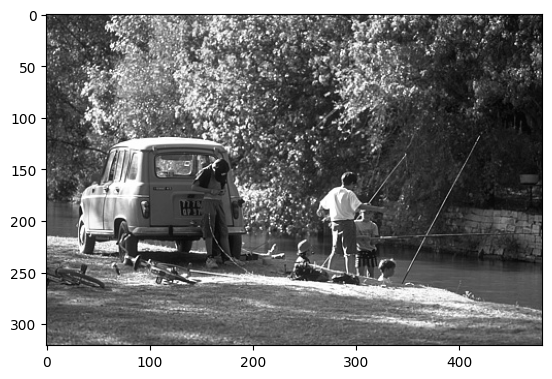

In [ ]:

def load_images(path):
    images = []
    for image in os.listdir(path):
        if image.endswith(".jpg") or image.endswith(".png") or image.endswith(".jpeg"):
            img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

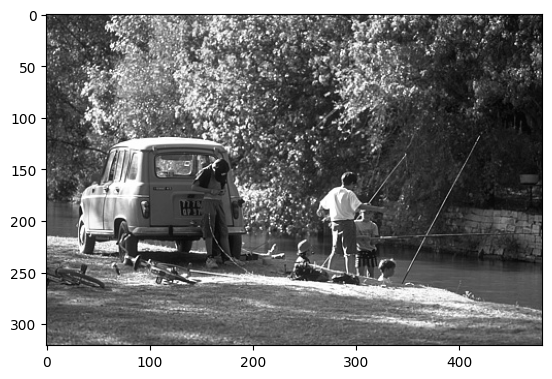

In [8]:

images = load_images(f"{os.getcwd()}/BSDS500/BSDS500/data/images/test")

plt.imshow(images[0], cmap='gray')

## Aplicar filtro anisotropico

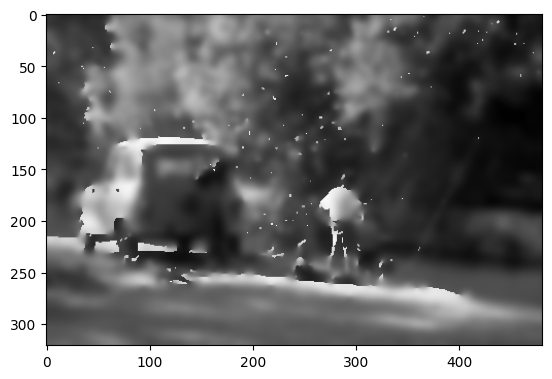

In [4]:
def apply_anisotropic_filter(image, niter=50, kappa=50, gamma=0.2, step=(1.,1.), option=1, ploton=False):
    """
    Apply anisotropic diffusion filter to an image.
    
    Parameters:
    - image: Input image (numpy array).
    - niter: Number of iterations.
    - kappa: Conductance coefficient.
    - gamma: Time step.
    - option: Option for the diffusion equation (1 or 2).
    
    Returns:
    - Filtered image.
    """
    return anisodiff(image, niter=niter, kappa=kappa, gamma=gamma, option=option)

def apply_filter_to_images(images, niter=50, kappa=50, gamma=0.2, step=(1.,1.), option=1):
    """
    Apply anisotropic diffusion filter to a list of images.
    
    Parameters:
    - images: List of input images (numpy arrays).
    - niter: Number of iterations.
    - kappa: Conductance coefficient.
    - gamma: Time step.
    - option: Option for the diffusion equation (1 or 2).
    
    Returns:
    - List of filtered images.
    """
    filtered_images = []
    for img in images:
        filtered_img = apply_anisotropic_filter(img, niter=niter, kappa=kappa, gamma=gamma, step=step, option=option)
        filtered_images.append(filtered_img)
    return filtered_images
filtered_images = apply_filter_to_images(images, niter=50, kappa=50, gamma=0.2, step=(1.,1.), option=1)

plt.imshow(filtered_images[0], cmap='gray')

## Producir coleccion de ventanas de muestra k * k

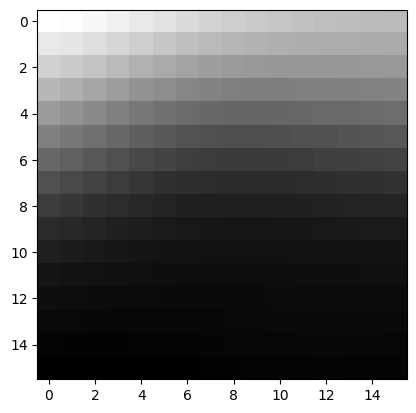

In [5]:
def extraer_ventanas_aleatorias(original_image, filtered_image, k=16, num_samples=5):
    
    h, w = original_image.shape[0], original_image.shape[1]
    x = []
    y = []
    coordenadas = set() # para evitar coordenadas repetidas
    # Asegurarse de que el número de muestras no exceda el número posible de ventanas
    max_samples = (h - k + 1) * (w - k + 1)
    if num_samples > max_samples:
        raise ValueError(f"num_samples ({num_samples}) exceeds the maximum possible windows ({max_samples}).")
    # Extraer ventanas aleatorias
    if num_samples < 1:
        raise ValueError("num_samples must be at least 1.")
    if k <= 0:
        raise ValueError("k must be a positive integer.")
    if h < k or w < k:
        raise ValueError("Image dimensions must be larger than k.")
    if not isinstance(original_image, np.ndarray) or not isinstance(filtered_image, np.ndarray):
        raise ValueError("original_image and filtered_image must be numpy arrays.")
    if original_image.shape != filtered_image.shape:
        raise ValueError("original_image and filtered_image must have the same dimensions.")
    if len(original_image.shape) != 2 or len(filtered_image.shape) != 2:
        raise ValueError("original_image and filtered_image must be 2D arrays (grayscale images).")
    if num_samples < 1 or k <= 0 or h < k or w < k:
        raise ValueError("Invalid parameters: num_samples must be at least 1, k must be a positive integer, and image dimensions must be larger than k.")
    i, j = 0, 0
    for _ in range(num_samples):
        # Asegurarse de que las coordenadas no se repitan
        while True:
            i = random.randint(0, h - k)
            j = random.randint(0, w - k)
            if (i, j) not in coordenadas:
                coordenadas.add((i, j))
                break        
        # Extraer ventanas
        xi = original_image[i:i+k, j:j+k]
        yi = filtered_image[i:i+k, j:j+k]
        
        x.append(xi)
        y.append(yi)
    
    return np.array(x), np.array(y)

def crear_base_de_datos_de_ventanas(original_images, filtered_images, k=16, num_samples=5):
    """
    Crear una base de datos de ventanas aleatorias a partir de imágenes originales y filtradas.
    
    Parameters:
    - original_images: Lista de imágenes originales (numpy arrays).
    - filtered_images: Lista de imágenes filtradas (numpy arrays).
    - k: Tamaño de la ventana.
    - num_samples: Número de muestras por imagen.
    
    Returns:
    - x: Ventanas extraídas de las imágenes originales.
    - y: Ventanas extraídas de las imágenes filtradas.
    """
    x = []
    y = []
    
    for original_image, filtered_image in zip(original_images, filtered_images):
        xi, yi = extraer_ventanas_aleatorias(original_image, filtered_image, k=k, num_samples=num_samples)
        x.append(xi)
        y.append(yi)
    
    return np.concatenate(x), np.concatenate(y)
x, y = crear_base_de_datos_de_ventanas(images, filtered_images, k=16, num_samples=2500) # Son 200 ventanas por imagen 2500 * 200 = 500000 = 5*10^5
plt.imshow(x[0], cmap='gray')
plt.imshow(y[0], cmap='gray')

## Guardar la db para que no se tenga que andar generando cada vez que se cargue el programa

In [7]:
def save_image(image, filename):
    """
    Save an image to a file.
    
    Parameters:
    - image: Input image (numpy array).
    - filename: Name of the file to save the image.
    """
    cv2.imwrite(filename, image)
    
def save_images(original_images, filtered_images, directory):
    """
    Save a list of images to a specified directory.
    
    Parameters:
    - images: List of input images (numpy arrays).
    - directory: Directory where the images will be saved.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for i, img in enumerate(original_images):
        save_image(
            img, 
            filename = os.path.join(directory, f'original_image_{i}.png')
            )
        save_image(
            filtered_images[i], 
            os.path.join(directory, f'filtered_image_{i}.png')
            )

save_images(x, y, f"{os.getcwd()}/data/")

[ WARN:0@435.474] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


## Cargar dataset

In [ ]:
def load_images(path):
    original_images = []
    filtered_images = []
    for image in os.listdir(path):
        if re.search(r'original', image) and (image.endswith(".jpg") or image.endswith(".png") or image.endswith(".jpeg")):
            img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                original_images.append(img)
        elif re.search(r'filtered', image) and (image.endswith(".jpg") or image.endswith(".png") or image.endswith(".jpeg")):
            img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                filtered_images.append(img)
    return original_images, filtered_images
x, y = load_images(f"{os.getcwd()}/data/")

## Separar entre conjuntos de validacion, entrenamiento y prueba

In [ ]:
train_dataset_x = 
train_dataset_y = 